In [ ]:
%matplotlib inline
from numpy import linspace, log, exp
from numpy.random import normal
from lmfit import Model
import seaborn as sns
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1)

# The likelihood ratio test: Python implementation

For two models, one nested in the other (meaning that the nested model estimated parameters are a subset of the nesting model), the test statistic $D$ is (based on [this](http://www.stat.sc.edu/~habing/courses/703/GLRTExample.pdf)):

$$
\Lambda = \Big( \Big(\frac{\sum{(X_i - \hat{X_i}(\theta_1))^2}}{\sum{(X_i - \hat{X_i}(\theta_0))^2}}\Big)^{n/2} \Big) \\
D = -2 log \Lambda \\
lim_{n \to \infty} D \sim \chi^2_{df=\Delta}
$$

where $\Lambda$ is the likelihood ratio, $D$ is the statistic, $X_{i}$ are the data points, $\hat{X_i}(\theta)$ is the model prediction with parameters $\theta$, $\theta_i$ is the parameters estimation for model $i$, $n$ is the number of data points and $\Delta$ is the difference in number of parameters between the models.

The python implementation below compares between two `lmfit.ModelFit` objects. These are the results of fitting models to the same data set using the [`lmfit` package](lmfit.github.io/lmfit-py/). 

The function compares between model fit `m0` and `m1` and assumes that `m0` is nested in `m1`, meaning that the set of varying parameters of `m0` is a subset of the varying parameters of `m1`. The property `chisqr` of the `ModelFit` objects is the sum of the square of the residuals of the fit. `ndata` is the number of data points. `nvarys` is the number of varying parameters.

In [2]:
def lrtest(m0, m1):
    n0 = m0.ndata
    k0 = m0.nvarys
    chisqr0 = m0.chisqr
    assert chisqr0 > 0
    n1 = m1.ndata
    assert n0 == n1
    k1 = m1.nvarys
    chisqr1 = m1.chisqr
    assert chisqr1 > 0
    Lambda = (m1.chisqr / m0.chisqr)**(n0 / 2.)
    D = -2 * log( Lambda )
    assert D > 0
    ddf = k1 - k0
    assert ddf > 0
    return stats.chisqprob(D, ddf), D, ddf

## Test on a simple model

We test the function on data generated from the equation:

$$
y = b + e^{-a t} + N(0, \sigma^2)
$$

where $a$ and $b$ are the parameters, $t$ is the variable, and $N$ is the normal distribution.

We fit a nesting model `model_fit1` (the alternative hypothesis of the test). This model estimates both $a$ and $b$.
We also fit a nested model `model_fit0` (the nul hypothesis of the test) in which either $a$ or $b$ is fixed at an initial value.
We than plot both model fits, print the estimated parameters, the test statistic and the p-value of the test.

In [4]:
# test lrt
def lrt_test(a, b, a_init, b_init, a_vary, b_vary, sig=0.1, N=100):
    assert a_vary or b_vary
    assert not(a_vary and b_vary)
       
    t = linspace(0,1,N)
    f = lambda t,a,b: b + exp(-a*t)
    data = f(t,a,b) + normal(0, sig, N)
    fig, ax = subplots(1,2,sharex=True,sharey=True,figsize=(15,5))
    print "real:", a,b
    model = Model(f)
    params = model.make_params(a=a_init, b=b_init)

    model_fit1 = model.fit(data, t=t, params=params)
    model_fit1.plot_fit(ax=ax[1])
    ax[1].set_title("Alternative")
    #model_fit1.plot_residuals(ax[1])
    print "H1:",model_fit1.best_values

    params['a'].set(vary=a_vary)
    params['b'].set(vary=b_vary)
    model_fit0 = model.fit(data, t=t, params=params)
    model_fit0.plot_fit(ax=ax[0])
    #model_fit0.plot_residuals(ax[0])
    ax[0].set_title("Null")
    print "H0:",model_fit0.best_values

    pval,D,ddf = lrtest(model_fit0, model_fit1)
    print "pval", pval, "D", D, "ddf", ddf
    return t,data

real: 1 1
H1: {'a': 1.0800926120783894, 'b': 1.0284477550237698}
H0: {'a': 1, 'b': 1.0078552102769249}
pval 0.394185790318 D 0.725990894661 ddf 1


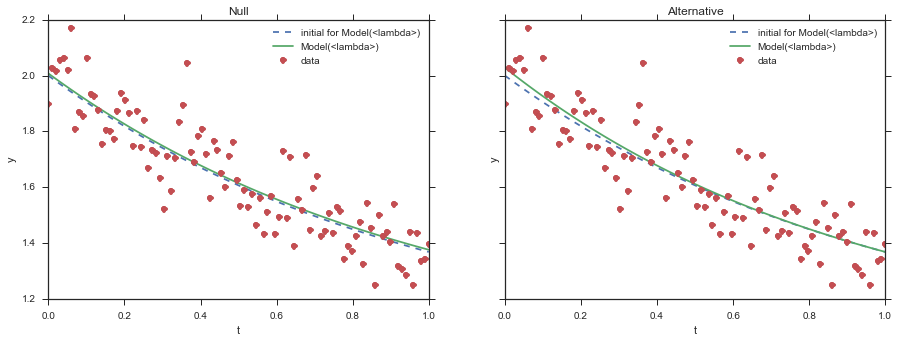

In [10]:
lrt_test(1,1,1,1,False,True);

real: 1 1
H1: {'a': 0.99844108164002598, 'b': 1.0111376997155404}
H0: {'a': 0.96263834314508268, 'b': 1}
pval 0.660344788754 D 0.193105038239 ddf 1


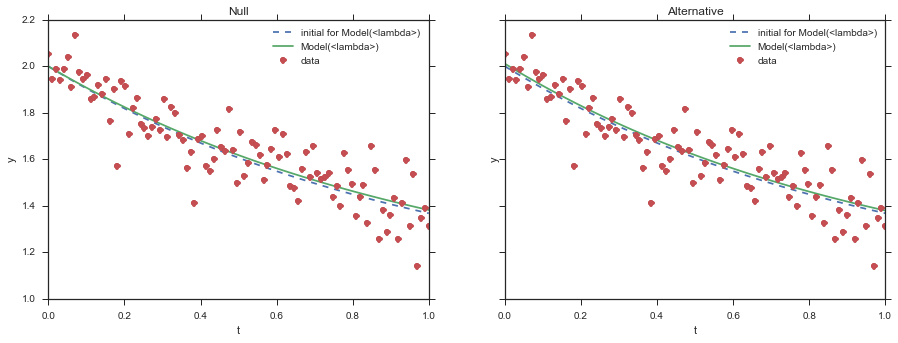

In [11]:
lrt_test(1,1,1,1,True,False);

real: 1 1
H1: {'a': 0.96102998872098322, 'b': 0.97443412304684873}
H0: {'a': -0.56666022012273554, 'b': 0}
pval 6.8550858208e-75 D 335.265355672 ddf 1


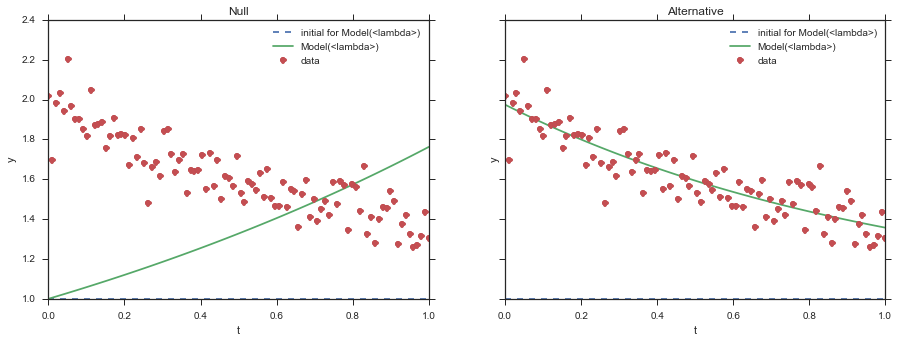

In [12]:
lrt_test(1,1,0,0,True,False);

real: 1 1
H1: {'a': 0.97393249249148883, 'b': 0.97727377724271791}
H0: {'a': 0, 'b': 0.6168397979217527}
pval 2.082903506e-36 D 158.787051236 ddf 1


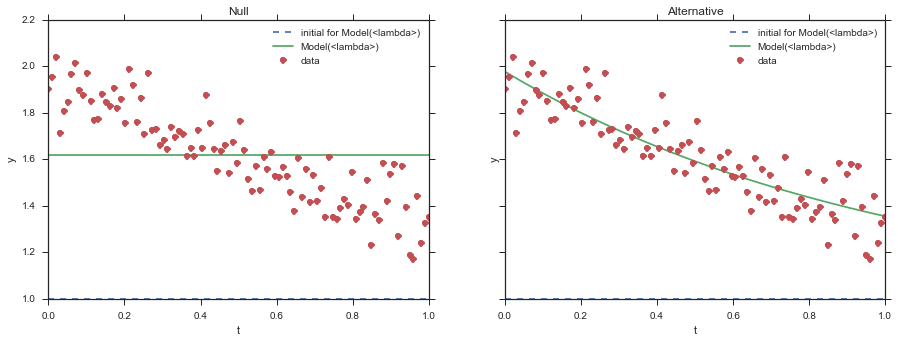

In [13]:
lrt_test(1,1,0,0,False,True);

real: 1 1
H1: {'a': 0.93685488219531721, 'b': 0.97449395922119753}
H0: {'a': 0, 'b': 0.62409786417086777}
pval 1.03405132161e-28 D 123.593349809 ddf 1


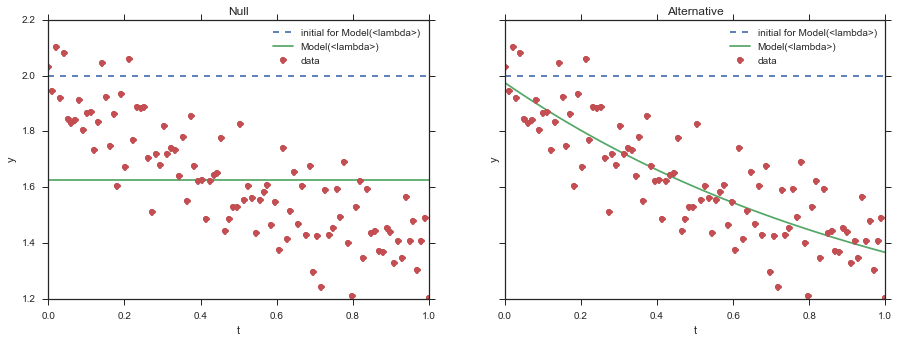

In [14]:
lrt_test(1,1,0,1,False,True);

real: 1 1
H1: {'a': 1.0830384492394496, 'b': 1.0154037885642835}
H0: {'a': 1.0305686867603605, 'b': 1}
pval 0.520530931265 D 0.412841208958 ddf 1


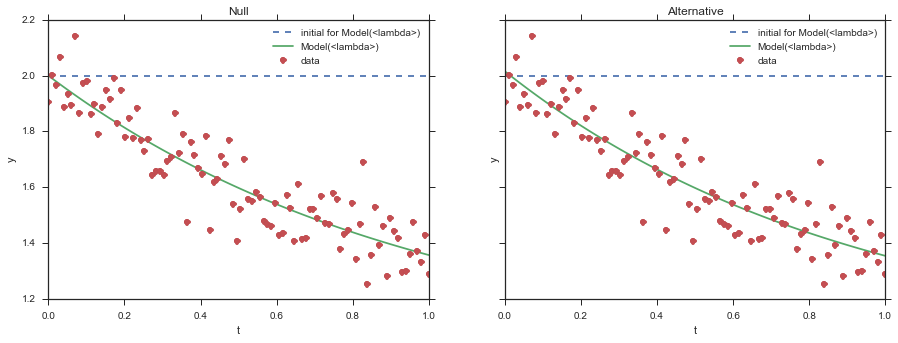

In [15]:
lrt_test(1,1,0,1,True,False);

real: 1 1
H1: {'a': 0.93582987437875442, 'b': 0.97950595108531602}
H0: {'a': -0.58216261111702472, 'b': 0}
pval 1.34809253967e-69 D 310.96172821 ddf 1


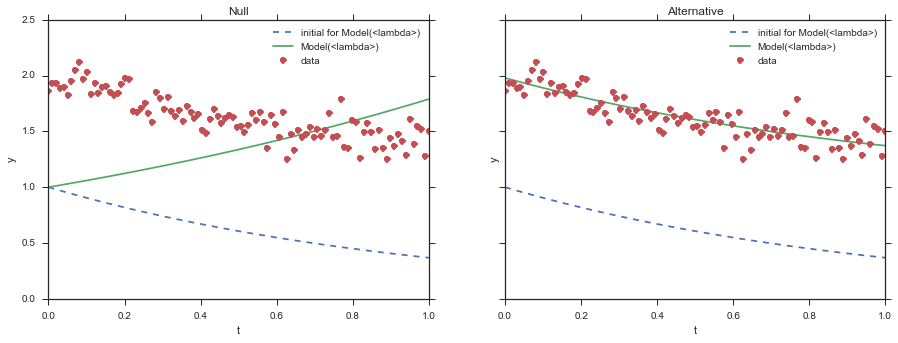

In [16]:
lrt_test(1,1,1,0,True,False);

real: 1 1
H1: {'a': 1.0018565017744423, 'b': 0.99701527991706873}
H0: {'a': 1, 'b': 0.99652651291672878}
pval 0.982540634786 D 0.000478901395011 ddf 1


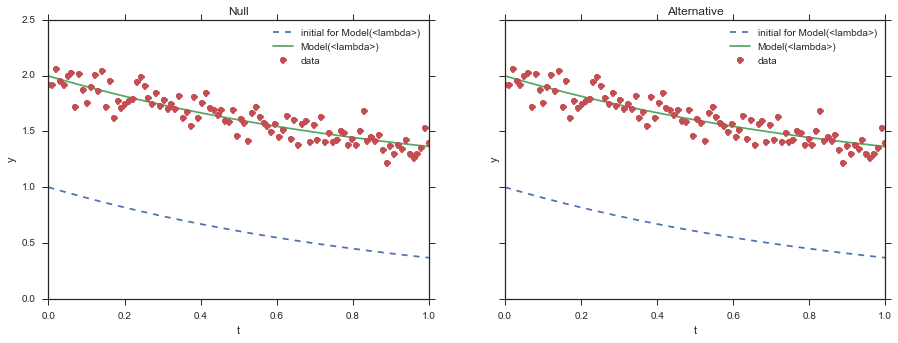

In [17]:
lrt_test(1,1,1,0,False,True);

real: 1 1
H1: {'a': 1.0190577775963174, 'b': 1.0126864110363802}
H0: {'a': 2, 'b': 1.2066389232684271}
pval 1.10522915563e-11 D 46.1324448303 ddf 1


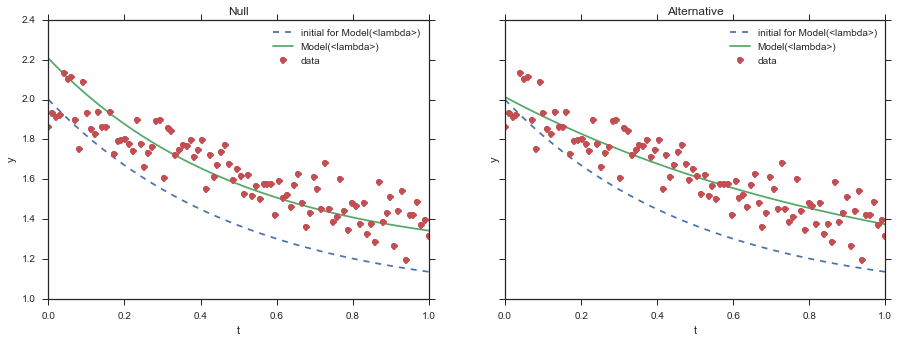

In [18]:
lrt_test(1,1,2,1,False,True);

## Compare with R

Here we compare the Python implementation with the R implementation - `lmtest::lrtest`. The data is generated from a quadratic polynomial:

$$
y = at^2 + bt + c + N(0,\sigma^2)
$$

and we fit two models - the nested model is a linear function and the nesting model is a quadratic polynomial.

### Note

In order to get this to work you will need to make sure the `lmtest` package is installed (don't install via RStudio - use regular command line R) and that the %R_HOME% and %R_USER% are set to where R is running from the command line and where the packages are installed to when running from the command line.

In [3]:
%load_ext rpy2.ipython

In [23]:
!echo %R_HOME%
!echo %R_USER%

C:/Progra~1/R/R-3.0.3
C:\Users\yoavram\R


In [46]:
for _ in range(10):
    N = 100
    sig = 0.1
    a,b,c = 0.1,1,1
    t = linspace(0,1,N)
    f = lambda t,a,b,c: c + b*t + a*t**2
    data = f(t,a,b,c) + normal(0, sig, N)
    model = Model(f)
    params = model.make_params(a=0, b=0, c=0)

    model_fit1 = model.fit(data, t=t, params=params)

    params['a'].set(vary=False)
    model_fit0 = model.fit(data, t=t, params=params)

    pval,D,ddf = lrtest(model_fit0, model_fit1)
    print "py",
    print pval

    print "R ",
    %Rpush t data
    %R library(lmtest)
    %R lm1=lm(data~t)
    %R lm2=lm(data~t+I(t^2))
    %R pvalue = lrtest(lm2,lm1)[2,5]
    %Rpull pvalue
    print pvalue[0]

py 0.0614918169425
R  0.0614918169425
py 0.70181434391
R  0.70181434391
py 0.00113346939514
R  0.00113346939514
py 0.927722599672
R  0.927722599672
py 0.961035895434
R  0.961035895434
py 0.228270810034
R  0.228270810034
py 0.891594844099
R  0.891594844099
py 0.162566935785
R  0.162566935785
py 0.462609931467
R  0.462609931467
py 0.227814653047
R  0.227814653047


## License

This notebook was written by [Yoav Ram](http://www.yoavram.com) and [Uri Obolski](https://sites.google.com/site/hadanylab/people/uri-obolski). The latest version can be found at [ipython.yoavram.com](http://nbviewer.ipython.org/github/yoavram/ipython-notebooks/blob/master/likelihood%20ratio%20test.ipynb). 

The code is released with a CC-BY-SA 3.0 license.